# DPG for Cartpole


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/home/aras/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [6]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.7624350806679216 -3.068177803455336
actions: 1 0
rewards: 1.0 1.0


In [7]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [8]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [9]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [10]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    rates = tf.placeholder(tf.float32, [None], name='rates')
    return states, actions, targetQs, rates

In [11]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [12]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [13]:
def model_loss(action_size, hidden_size, states, actions, targetQs, rates):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                              labels=actions_labels)
    targetQs = tf.reshape(targetQs, shape=[-1, 1])
    gloss = tf.reduce_mean(neg_log_prob * targetQs) # DPG: r+(gamma*nextQ)
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True) # Qs
    rates = tf.reshape(rates, shape=[-1, 1])
    dlossA = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                    labels=rates)) # 0-1
    dlossA += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                     labels=rates)) # 0-1
    dlossA /= 2
    dlossQ = tf.reduce_mean(tf.square(gQs - targetQs)) # DQN
    dlossQ += tf.reduce_mean(tf.square(dQs - targetQs)) # DQN
    dlossQ /= 2
    return actions_logits, gQs, gloss, dlossA, dlossQ

In [14]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_lossA, d_lossQ, g_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        d_optA = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossA, var_list=d_vars)
        d_optQ = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossQ, var_list=d_vars)

    return g_opt, d_optA, d_optQ

In [15]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, g_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.rates = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_lossA, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, 
            targetQs=self.targetQs, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_optA, self.d_optQ = model_opt(g_loss=self.g_loss, 
                                                         d_lossA=self.d_lossA, 
                                                         d_lossQ=self.d_lossQ, 
                                                         g_learning_rate=g_learning_rate, 
                                                         d_learning_rate=d_learning_rate)

In [16]:
def sample(batch_size, ListArr):
    idx = np.random.choice(np.arange(len(ListArr)), 
                           size=batch_size, 
                           replace=True)
    return [ListArr[ii] for ii in idx]

In [17]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), 
#                                size=batch_size, 
#                                replace=False)
#         return [self.buffer[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [18]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [19]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
g_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e2)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [20]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [21]:
# Initializing the memory with the pool of random exploration of the env.
goal = 500 # env-based, the total reward required for reaching the goal G
state = env.reset() # env-based
total_reward = 0 # episode R
num_step = 0 # episode steps/ length based on number of steps
for _ in range(memory_size):
    action = env.action_space.sample() # exploring the env action space/ random action/ explore
    next_state, reward, done, _ = env.step(action) # exploring the env state, reward, and done/end
    memory.buffer.append([state, action, next_state, reward, float(done), -1])
    num_step += 1 # memory incremented
    total_reward += reward # R += r
    state = next_state # update the state for next episode
    if done is True: # end of this episode
        state = env.reset() # reset for next episode
        rate = total_reward/goal # the actual sucess rate of the played sequence
        total_reward = 0 # reset for next episode
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][5] == -1: # double-check if it is empty and it is not rated!
                memory.buffer[-1-idx][5] = rate # rate each SA pair
        num_step = 0 # reset for the next episode

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [22]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list = [] # goal
rewards_list, gloss_list, dloss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(1111):
        total_reward = 0 # each episode
        gloss_batch, dlossA_batch, dlossQ_batch= [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
                #print(action)
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits) # adding epsilon*noise
                #print(action)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done), -1])
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the last played episode
            if done is True:
                rate = total_reward/ goal # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.buffer[-1-idx][5] == -1: # double-check if it is empty and it is not rated!
                        memory.buffer[-1-idx][5] = rate # rate each SA pair
                        
            # Rating and training the memory
            allrates = np.array(memory.buffer)[:, 5]
            rated_mem = np.array(memory.buffer)[allrates >= (max(allrates)*0.1)]
            batch = sample(ListArr=rated_mem, batch_size=batch_size)
            #mem = np.array(memory.buffer)
            #batch = sample(ListArr=mem, batch_size=batch_size)
            #batch = sample(ListArr=memory.buffer, batch_size=batch_size)
            #batch = memory.sample(batch_size=batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            next_states = np.array([each[2] for each in batch])
            rewards = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            rates = np.array([each[5] for each in batch])
            nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states})
            #nextQs = np.max(nextQs_logits, axis=1) * (1-dones) # DQN
            nextQs = nextQs_logits.reshape([-1]) * (1-dones) # DPG
            targetQs = rewards + (gamma * nextQs)
            gloss, dlossA, dlossQ, _, _, _ = sess.run([model.g_loss, model.d_lossA, model.d_lossQ, 
                                                       model.g_opt, model.d_optA, model.d_optQ],
                                                      feed_dict = {model.states: states, 
                                                                   model.actions: actions,
                                                                   model.targetQs: targetQs, 
                                                                   model.rates: rates})
            gloss_batch.append(gloss)
            dlossA_batch.append(dlossA)
            dlossQ_batch.append(dlossQ)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'dlossA:{:.4f}'.format(np.mean(dlossA_batch)),
              'dlossQ:{:.4f}'.format(np.mean(dlossQ_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        #gloss_list.append([ep, np.mean(gloss_batch)])
        #dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:26.0000 R:26.0000 rate:0.0520 gloss:0.8124 dlossA:0.8059 dlossQ:0.8952 exploreP:0.9974
Episode:1 meanR:26.0000 R:26.0000 rate:0.0520 gloss:0.8095 dlossA:0.8056 dlossQ:0.9011 exploreP:0.9949
Episode:2 meanR:27.3333 R:30.0000 rate:0.0600 gloss:0.8051 dlossA:0.8023 dlossQ:0.9058 exploreP:0.9919
Episode:3 meanR:23.5000 R:12.0000 rate:0.0240 gloss:0.8030 dlossA:0.8032 dlossQ:0.9071 exploreP:0.9907
Episode:4 meanR:22.8000 R:20.0000 rate:0.0400 gloss:0.8064 dlossA:0.8062 dlossQ:0.8978 exploreP:0.9888
Episode:5 meanR:21.0000 R:12.0000 rate:0.0240 gloss:0.8065 dlossA:0.8073 dlossQ:0.8898 exploreP:0.9876
Episode:6 meanR:21.5714 R:25.0000 rate:0.0500 gloss:0.8105 dlossA:0.8042 dlossQ:0.9111 exploreP:0.9852
Episode:7 meanR:21.8750 R:24.0000 rate:0.0480 gloss:0.7957 dlossA:0.8057 dlossQ:0.8897 exploreP:0.9828
Episode:8 meanR:21.3333 R:17.0000 rate:0.0340 gloss:0.8000 dlossA:0.8073 dlossQ:0.8965 exploreP:0.9812
Episode:9 meanR:20.1000 R:9.0000 rate:0.0180 gloss:0.8025 dlossA:0.8043 d

Episode:79 meanR:27.5750 R:63.0000 rate:0.1260 gloss:0.8120 dlossA:0.8089 dlossQ:0.9153 exploreP:0.8040
Episode:80 meanR:27.4568 R:18.0000 rate:0.0360 gloss:0.8113 dlossA:0.8123 dlossQ:0.9101 exploreP:0.8026
Episode:81 meanR:27.4024 R:23.0000 rate:0.0460 gloss:0.8035 dlossA:0.8099 dlossQ:0.9003 exploreP:0.8008
Episode:82 meanR:27.3614 R:24.0000 rate:0.0480 gloss:0.8083 dlossA:0.8071 dlossQ:0.9118 exploreP:0.7989
Episode:83 meanR:27.2976 R:22.0000 rate:0.0440 gloss:0.8085 dlossA:0.8082 dlossQ:0.9134 exploreP:0.7971
Episode:84 meanR:27.2824 R:26.0000 rate:0.0520 gloss:0.8146 dlossA:0.8082 dlossQ:0.9253 exploreP:0.7951
Episode:85 meanR:27.6628 R:60.0000 rate:0.1200 gloss:0.8102 dlossA:0.8082 dlossQ:0.9160 exploreP:0.7904
Episode:86 meanR:27.9195 R:50.0000 rate:0.1000 gloss:0.8083 dlossA:0.8080 dlossQ:0.9127 exploreP:0.7865
Episode:87 meanR:27.7159 R:10.0000 rate:0.0200 gloss:0.8118 dlossA:0.8106 dlossQ:0.9135 exploreP:0.7857
Episode:88 meanR:27.8539 R:40.0000 rate:0.0800 gloss:0.8099 dlos

Episode:158 meanR:31.7100 R:25.0000 rate:0.0500 gloss:0.8171 dlossA:0.8079 dlossQ:0.9319 exploreP:0.6299
Episode:159 meanR:32.2200 R:86.0000 rate:0.1720 gloss:0.8176 dlossA:0.8099 dlossQ:0.9274 exploreP:0.6246
Episode:160 meanR:32.1200 R:34.0000 rate:0.0680 gloss:0.8194 dlossA:0.8097 dlossQ:0.9310 exploreP:0.6225
Episode:161 meanR:32.1000 R:43.0000 rate:0.0860 gloss:0.8158 dlossA:0.8107 dlossQ:0.9227 exploreP:0.6198
Episode:162 meanR:32.0800 R:21.0000 rate:0.0420 gloss:0.8146 dlossA:0.8084 dlossQ:0.9234 exploreP:0.6186
Episode:163 meanR:32.2200 R:29.0000 rate:0.0580 gloss:0.8126 dlossA:0.8110 dlossQ:0.9126 exploreP:0.6168
Episode:164 meanR:32.3300 R:29.0000 rate:0.0580 gloss:0.8202 dlossA:0.8109 dlossQ:0.9307 exploreP:0.6150
Episode:165 meanR:32.4200 R:40.0000 rate:0.0800 gloss:0.8225 dlossA:0.8103 dlossQ:0.9361 exploreP:0.6126
Episode:166 meanR:32.4600 R:18.0000 rate:0.0360 gloss:0.8149 dlossA:0.8100 dlossQ:0.9210 exploreP:0.6115
Episode:167 meanR:32.2300 R:37.0000 rate:0.0740 gloss:0

Episode:237 meanR:42.6000 R:43.0000 rate:0.0860 gloss:0.8345 dlossA:0.8131 dlossQ:0.9532 exploreP:0.4437
Episode:238 meanR:42.5100 R:25.0000 rate:0.0500 gloss:0.8397 dlossA:0.8134 dlossQ:0.9600 exploreP:0.4426
Episode:239 meanR:42.6400 R:43.0000 rate:0.0860 gloss:0.8352 dlossA:0.8132 dlossQ:0.9561 exploreP:0.4407
Episode:240 meanR:42.7300 R:67.0000 rate:0.1340 gloss:0.8320 dlossA:0.8137 dlossQ:0.9501 exploreP:0.4379
Episode:241 meanR:42.7900 R:43.0000 rate:0.0860 gloss:0.8382 dlossA:0.8130 dlossQ:0.9601 exploreP:0.4360
Episode:242 meanR:42.9100 R:43.0000 rate:0.0860 gloss:0.8335 dlossA:0.8134 dlossQ:0.9522 exploreP:0.4342
Episode:243 meanR:43.0900 R:50.0000 rate:0.1000 gloss:0.8357 dlossA:0.8128 dlossQ:0.9583 exploreP:0.4321
Episode:244 meanR:43.8000 R:101.0000 rate:0.2020 gloss:0.8363 dlossA:0.8146 dlossQ:0.9543 exploreP:0.4278
Episode:245 meanR:44.9300 R:167.0000 rate:0.3340 gloss:0.8346 dlossA:0.8139 dlossQ:0.9534 exploreP:0.4209
Episode:246 meanR:45.2900 R:69.0000 rate:0.1380 gloss

Episode:315 meanR:60.9000 R:51.0000 rate:0.1020 gloss:0.8450 dlossA:0.8158 dlossQ:0.9617 exploreP:0.2740
Episode:316 meanR:61.0800 R:36.0000 rate:0.0720 gloss:0.8466 dlossA:0.8172 dlossQ:0.9633 exploreP:0.2730
Episode:317 meanR:61.4600 R:85.0000 rate:0.1700 gloss:0.8447 dlossA:0.8175 dlossQ:0.9589 exploreP:0.2708
Episode:318 meanR:61.4800 R:67.0000 rate:0.1340 gloss:0.8429 dlossA:0.8174 dlossQ:0.9566 exploreP:0.2691
Episode:319 meanR:62.2900 R:163.0000 rate:0.3260 gloss:0.8460 dlossA:0.8185 dlossQ:0.9590 exploreP:0.2649
Episode:320 meanR:62.2500 R:56.0000 rate:0.1120 gloss:0.8483 dlossA:0.8190 dlossQ:0.9628 exploreP:0.2635
Episode:321 meanR:62.7500 R:86.0000 rate:0.1720 gloss:0.8386 dlossA:0.8157 dlossQ:0.9524 exploreP:0.2613
Episode:322 meanR:62.9000 R:61.0000 rate:0.1220 gloss:0.8431 dlossA:0.8172 dlossQ:0.9553 exploreP:0.2598
Episode:323 meanR:62.5200 R:83.0000 rate:0.1660 gloss:0.8400 dlossA:0.8167 dlossQ:0.9546 exploreP:0.2577
Episode:324 meanR:63.3500 R:111.0000 rate:0.2220 gloss

Episode:393 meanR:78.8800 R:83.0000 rate:0.1660 gloss:0.8555 dlossA:0.8242 dlossQ:0.9683 exploreP:0.1487
Episode:394 meanR:79.3600 R:78.0000 rate:0.1560 gloss:0.8589 dlossA:0.8262 dlossQ:0.9681 exploreP:0.1476
Episode:395 meanR:79.1900 R:63.0000 rate:0.1260 gloss:0.8546 dlossA:0.8264 dlossQ:0.9674 exploreP:0.1468
Episode:396 meanR:79.5100 R:72.0000 rate:0.1440 gloss:0.8584 dlossA:0.8270 dlossQ:0.9695 exploreP:0.1458
Episode:397 meanR:79.3200 R:65.0000 rate:0.1300 gloss:0.8543 dlossA:0.8256 dlossQ:0.9658 exploreP:0.1449
Episode:398 meanR:79.8300 R:74.0000 rate:0.1480 gloss:0.8554 dlossA:0.8261 dlossQ:0.9675 exploreP:0.1439
Episode:399 meanR:79.6300 R:69.0000 rate:0.1380 gloss:0.8598 dlossA:0.8280 dlossQ:0.9767 exploreP:0.1430
Episode:400 meanR:79.9600 R:67.0000 rate:0.1340 gloss:0.8585 dlossA:0.8292 dlossQ:0.9691 exploreP:0.1421
Episode:401 meanR:80.2500 R:93.0000 rate:0.1860 gloss:0.8575 dlossA:0.8270 dlossQ:0.9705 exploreP:0.1409
Episode:402 meanR:80.3800 R:65.0000 rate:0.1300 gloss:0

Episode:471 meanR:80.1100 R:107.0000 rate:0.2140 gloss:0.8785 dlossA:0.8432 dlossQ:1.0110 exploreP:0.0846
Episode:472 meanR:80.3000 R:77.0000 rate:0.1540 gloss:0.8847 dlossA:0.8438 dlossQ:1.0167 exploreP:0.0840
Episode:473 meanR:79.6000 R:78.0000 rate:0.1560 gloss:0.8852 dlossA:0.8449 dlossQ:1.0180 exploreP:0.0835
Episode:474 meanR:79.5300 R:72.0000 rate:0.1440 gloss:0.8812 dlossA:0.8451 dlossQ:1.0078 exploreP:0.0829
Episode:475 meanR:79.6600 R:92.0000 rate:0.1840 gloss:0.8786 dlossA:0.8444 dlossQ:1.0111 exploreP:0.0823
Episode:476 meanR:79.7300 R:76.0000 rate:0.1520 gloss:0.8801 dlossA:0.8423 dlossQ:1.0123 exploreP:0.0817
Episode:477 meanR:79.8600 R:91.0000 rate:0.1820 gloss:0.8797 dlossA:0.8441 dlossQ:1.0115 exploreP:0.0811
Episode:478 meanR:80.2700 R:129.0000 rate:0.2580 gloss:0.8832 dlossA:0.8457 dlossQ:1.0147 exploreP:0.0802
Episode:479 meanR:80.6700 R:78.0000 rate:0.1560 gloss:0.8851 dlossA:0.8463 dlossQ:1.0191 exploreP:0.0796
Episode:480 meanR:80.3600 R:74.0000 rate:0.1480 gloss

Episode:549 meanR:80.6400 R:58.0000 rate:0.1160 gloss:0.8827 dlossA:0.8558 dlossQ:1.0456 exploreP:0.0500
Episode:550 meanR:80.6600 R:92.0000 rate:0.1840 gloss:0.8913 dlossA:0.8560 dlossQ:1.0447 exploreP:0.0497
Episode:551 meanR:80.8300 R:81.0000 rate:0.1620 gloss:0.8849 dlossA:0.8565 dlossQ:1.0442 exploreP:0.0493
Episode:552 meanR:80.8000 R:85.0000 rate:0.1700 gloss:0.8853 dlossA:0.8561 dlossQ:1.0468 exploreP:0.0490
Episode:553 meanR:80.9200 R:83.0000 rate:0.1660 gloss:0.8877 dlossA:0.8561 dlossQ:1.0495 exploreP:0.0487
Episode:554 meanR:80.9900 R:77.0000 rate:0.1540 gloss:0.8823 dlossA:0.8569 dlossQ:1.0418 exploreP:0.0484
Episode:555 meanR:81.1700 R:85.0000 rate:0.1700 gloss:0.8804 dlossA:0.8563 dlossQ:1.0433 exploreP:0.0481
Episode:556 meanR:81.3700 R:114.0000 rate:0.2280 gloss:0.8913 dlossA:0.8579 dlossQ:1.0530 exploreP:0.0476
Episode:557 meanR:81.5000 R:80.0000 rate:0.1600 gloss:0.8924 dlossA:0.8577 dlossQ:1.0533 exploreP:0.0473
Episode:558 meanR:81.6100 R:94.0000 rate:0.1880 gloss:

Episode:627 meanR:82.5600 R:84.0000 rate:0.1680 gloss:0.8696 dlossA:0.8654 dlossQ:1.0819 exploreP:0.0308
Episode:628 meanR:82.5000 R:68.0000 rate:0.1360 gloss:0.8764 dlossA:0.8638 dlossQ:1.0813 exploreP:0.0306
Episode:629 meanR:82.5600 R:92.0000 rate:0.1840 gloss:0.8697 dlossA:0.8655 dlossQ:1.0724 exploreP:0.0304
Episode:630 meanR:82.2900 R:57.0000 rate:0.1140 gloss:0.8709 dlossA:0.8637 dlossQ:1.0751 exploreP:0.0303
Episode:631 meanR:82.2500 R:74.0000 rate:0.1480 gloss:0.8699 dlossA:0.8662 dlossQ:1.0751 exploreP:0.0302
Episode:632 meanR:82.6300 R:112.0000 rate:0.2240 gloss:0.8832 dlossA:0.8673 dlossQ:1.0872 exploreP:0.0300
Episode:633 meanR:82.5900 R:63.0000 rate:0.1260 gloss:0.8754 dlossA:0.8673 dlossQ:1.0811 exploreP:0.0298
Episode:634 meanR:82.8900 R:104.0000 rate:0.2080 gloss:0.8754 dlossA:0.8654 dlossQ:1.0802 exploreP:0.0296
Episode:635 meanR:82.6300 R:58.0000 rate:0.1160 gloss:0.8744 dlossA:0.8662 dlossQ:1.0825 exploreP:0.0295
Episode:636 meanR:83.1800 R:115.0000 rate:0.2300 glos

Episode:705 meanR:77.9400 R:67.0000 rate:0.1340 gloss:0.8474 dlossA:0.8743 dlossQ:1.1117 exploreP:0.0213
Episode:706 meanR:78.3000 R:103.0000 rate:0.2060 gloss:0.8558 dlossA:0.8763 dlossQ:1.1218 exploreP:0.0212
Episode:707 meanR:78.7100 R:110.0000 rate:0.2200 gloss:0.8533 dlossA:0.8740 dlossQ:1.1149 exploreP:0.0211
Episode:708 meanR:78.8200 R:77.0000 rate:0.1540 gloss:0.8593 dlossA:0.8761 dlossQ:1.1134 exploreP:0.0210
Episode:709 meanR:78.8200 R:64.0000 rate:0.1280 gloss:0.8572 dlossA:0.8743 dlossQ:1.1258 exploreP:0.0209
Episode:710 meanR:79.2200 R:103.0000 rate:0.2060 gloss:0.8592 dlossA:0.8740 dlossQ:1.1198 exploreP:0.0208
Episode:711 meanR:79.1800 R:81.0000 rate:0.1620 gloss:0.8563 dlossA:0.8755 dlossQ:1.1155 exploreP:0.0207
Episode:712 meanR:79.2600 R:75.0000 rate:0.1500 gloss:0.8483 dlossA:0.8732 dlossQ:1.1286 exploreP:0.0207
Episode:713 meanR:79.6300 R:107.0000 rate:0.2140 gloss:0.8453 dlossA:0.8759 dlossQ:1.1106 exploreP:0.0206
Episode:714 meanR:79.0700 R:60.0000 rate:0.1200 glo

Episode:783 meanR:80.0700 R:68.0000 rate:0.1360 gloss:0.8202 dlossA:0.8828 dlossQ:1.1617 exploreP:0.0160
Episode:784 meanR:80.3700 R:147.0000 rate:0.2940 gloss:0.8277 dlossA:0.8821 dlossQ:1.1539 exploreP:0.0159
Episode:785 meanR:80.3900 R:77.0000 rate:0.1540 gloss:0.8245 dlossA:0.8808 dlossQ:1.1628 exploreP:0.0159
Episode:786 meanR:80.6600 R:92.0000 rate:0.1840 gloss:0.8304 dlossA:0.8837 dlossQ:1.1456 exploreP:0.0158
Episode:787 meanR:80.8400 R:88.0000 rate:0.1760 gloss:0.8176 dlossA:0.8829 dlossQ:1.1457 exploreP:0.0158
Episode:788 meanR:80.9100 R:76.0000 rate:0.1520 gloss:0.8309 dlossA:0.8819 dlossQ:1.1718 exploreP:0.0157
Episode:789 meanR:80.8000 R:69.0000 rate:0.1380 gloss:0.8382 dlossA:0.8842 dlossQ:1.1613 exploreP:0.0157
Episode:790 meanR:80.8300 R:83.0000 rate:0.1660 gloss:0.8224 dlossA:0.8822 dlossQ:1.1596 exploreP:0.0157
Episode:791 meanR:81.0000 R:107.0000 rate:0.2140 gloss:0.8220 dlossA:0.8808 dlossQ:1.1533 exploreP:0.0156
Episode:792 meanR:80.8600 R:62.0000 rate:0.1240 gloss

Episode:861 meanR:80.6700 R:111.0000 rate:0.2220 gloss:0.7892 dlossA:0.8884 dlossQ:1.1722 exploreP:0.0132
Episode:862 meanR:80.5600 R:69.0000 rate:0.1380 gloss:0.7893 dlossA:0.8863 dlossQ:1.1573 exploreP:0.0132
Episode:863 meanR:81.1100 R:124.0000 rate:0.2480 gloss:0.7899 dlossA:0.8858 dlossQ:1.1824 exploreP:0.0131
Episode:864 meanR:80.8300 R:59.0000 rate:0.1180 gloss:0.7925 dlossA:0.8889 dlossQ:1.1806 exploreP:0.0131
Episode:865 meanR:80.9300 R:90.0000 rate:0.1800 gloss:0.7862 dlossA:0.8875 dlossQ:1.1852 exploreP:0.0131
Episode:866 meanR:80.6800 R:92.0000 rate:0.1840 gloss:0.7743 dlossA:0.8865 dlossQ:1.1779 exploreP:0.0131
Episode:867 meanR:80.6000 R:66.0000 rate:0.1320 gloss:0.7969 dlossA:0.8880 dlossQ:1.1949 exploreP:0.0131
Episode:868 meanR:80.6500 R:81.0000 rate:0.1620 gloss:0.7820 dlossA:0.8878 dlossQ:1.1837 exploreP:0.0130
Episode:869 meanR:80.6300 R:76.0000 rate:0.1520 gloss:0.7795 dlossA:0.8884 dlossQ:1.1784 exploreP:0.0130
Episode:870 meanR:80.5400 R:70.0000 rate:0.1400 gloss

Episode:939 meanR:77.5500 R:74.0000 rate:0.1480 gloss:0.7546 dlossA:0.8890 dlossQ:1.1831 exploreP:0.0118
Episode:940 meanR:77.1200 R:63.0000 rate:0.1260 gloss:0.7613 dlossA:0.8889 dlossQ:1.1759 exploreP:0.0117
Episode:941 meanR:77.1600 R:81.0000 rate:0.1620 gloss:0.7370 dlossA:0.8897 dlossQ:1.1815 exploreP:0.0117
Episode:942 meanR:77.3600 R:92.0000 rate:0.1840 gloss:0.7572 dlossA:0.8889 dlossQ:1.1835 exploreP:0.0117
Episode:943 meanR:77.2100 R:66.0000 rate:0.1320 gloss:0.7519 dlossA:0.8885 dlossQ:1.1886 exploreP:0.0117
Episode:944 meanR:77.1900 R:59.0000 rate:0.1180 gloss:0.7391 dlossA:0.8884 dlossQ:1.1862 exploreP:0.0117
Episode:945 meanR:77.2800 R:72.0000 rate:0.1440 gloss:0.7384 dlossA:0.8883 dlossQ:1.1754 exploreP:0.0117
Episode:946 meanR:77.9000 R:121.0000 rate:0.2420 gloss:0.7442 dlossA:0.8881 dlossQ:1.1872 exploreP:0.0117
Episode:947 meanR:77.8200 R:101.0000 rate:0.2020 gloss:0.7400 dlossA:0.8881 dlossQ:1.1895 exploreP:0.0116
Episode:948 meanR:77.6800 R:64.0000 rate:0.1280 gloss

Episode:1017 meanR:76.4100 R:63.0000 rate:0.1260 gloss:0.6958 dlossA:0.8917 dlossQ:1.1831 exploreP:0.0110
Episode:1018 meanR:76.8700 R:105.0000 rate:0.2100 gloss:0.6977 dlossA:0.8919 dlossQ:1.1914 exploreP:0.0110
Episode:1019 meanR:76.8000 R:84.0000 rate:0.1680 gloss:0.6967 dlossA:0.8913 dlossQ:1.1964 exploreP:0.0109
Episode:1020 meanR:76.8600 R:65.0000 rate:0.1300 gloss:0.6871 dlossA:0.8909 dlossQ:1.2005 exploreP:0.0109
Episode:1021 meanR:77.8900 R:170.0000 rate:0.3400 gloss:0.6909 dlossA:0.8920 dlossQ:1.1974 exploreP:0.0109
Episode:1022 meanR:77.9500 R:67.0000 rate:0.1340 gloss:0.6881 dlossA:0.8921 dlossQ:1.1963 exploreP:0.0109
Episode:1023 meanR:77.7300 R:61.0000 rate:0.1220 gloss:0.6892 dlossA:0.8904 dlossQ:1.1858 exploreP:0.0109
Episode:1024 meanR:77.6900 R:64.0000 rate:0.1280 gloss:0.6783 dlossA:0.8911 dlossQ:1.2015 exploreP:0.0109
Episode:1025 meanR:77.7900 R:76.0000 rate:0.1520 gloss:0.6742 dlossA:0.8921 dlossQ:1.1903 exploreP:0.0109
Episode:1026 meanR:77.3200 R:66.0000 rate:0.

Episode:1095 meanR:81.1600 R:112.0000 rate:0.2240 gloss:0.6458 dlossA:0.8918 dlossQ:1.1859 exploreP:0.0105
Episode:1096 meanR:80.7100 R:62.0000 rate:0.1240 gloss:0.6541 dlossA:0.8912 dlossQ:1.1813 exploreP:0.0105
Episode:1097 meanR:80.1700 R:57.0000 rate:0.1140 gloss:0.6464 dlossA:0.8925 dlossQ:1.1803 exploreP:0.0105
Episode:1098 meanR:80.5400 R:112.0000 rate:0.2240 gloss:0.6281 dlossA:0.8918 dlossQ:1.1813 exploreP:0.0105
Episode:1099 meanR:80.5400 R:66.0000 rate:0.1320 gloss:0.6390 dlossA:0.8919 dlossQ:1.1964 exploreP:0.0105
Episode:1100 meanR:80.6500 R:82.0000 rate:0.1640 gloss:0.6332 dlossA:0.8916 dlossQ:1.1880 exploreP:0.0105
Episode:1101 meanR:80.6400 R:72.0000 rate:0.1440 gloss:0.6334 dlossA:0.8907 dlossQ:1.1963 exploreP:0.0105
Episode:1102 meanR:80.7500 R:84.0000 rate:0.1680 gloss:0.6385 dlossA:0.8905 dlossQ:1.1977 exploreP:0.0105
Episode:1103 meanR:81.3300 R:127.0000 rate:0.2540 gloss:0.6253 dlossA:0.8915 dlossQ:1.1867 exploreP:0.0105
Episode:1104 meanR:81.5200 R:88.0000 rate:0

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

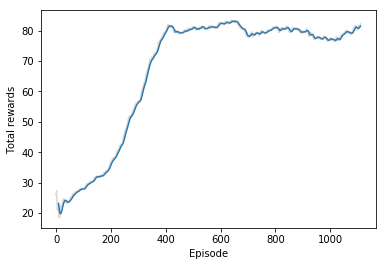

In [24]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

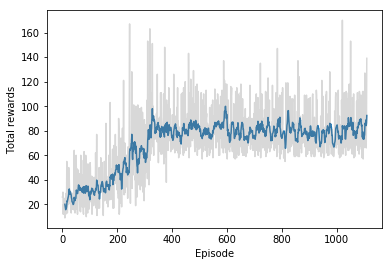

In [25]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

In [27]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

In [67]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.